# script to graph opentuner log

In [18]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import pandas as pd

# graph exec time vs. time in log file (--results-log-details)
def graph_log(log_name):
    data = pd.read_csv(log_name, sep=" ", names=["wallclock", "exectime"])
    plt.plot(data["wallclock"], data["exectime"], '-+', label='tuned', linewidth=1)
    plt.xlabel("Tuning Time (s)")
    plt.ylabel("Execution Time (s)")
    plt.legend()
    plt.show()

In [19]:
# graph exec time vs. tuning time in log file (--results-log-details)
def graph_tuning(log_name, mesh2d=0.0, mesh3d=0.0, torus2d=0.0, torus3d=0.0, axis="time", last=0):
    data = pd.read_csv(log_name, sep=" ", names=["wallclock", "exectime"])
    best_times = []
    best_time = data["exectime"][0]
    best_times.append(best_time)
    worst_time = 0.0
    for i in range(1, len(data["exectime"])):
        if data["exectime"][i] < best_time:
            best_time = data["exectime"][i]
        best_times.append(best_time)
    if mesh2d > 0.0:
        plt.axhline(y=mesh2d, xmin=0, xmax=1, linestyle='-', linewidth=1, color='red', label='2dmesh')
    if mesh3d > 0.0:
        plt.axhline(y=mesh3d, xmin=0, xmax=1, linestyle='-', linewidth=1, color='blue', label='3dmesh')  
    if torus2d > 0.0:
        plt.axhline(y=torus2d, xmin=0, xmax=1, linestyle='-', linewidth=1, color='green', label='2dtorus')   
    if torus3d > 0.0:
        plt.axhline(y=torus3d, xmin=0, xmax=1, linestyle='-', linewidth=1, color='brown', label='3dtorus')     
    max_time = max(data["exectime"][0], mesh2d, mesh3d, torus2d, torus3d)
    min_time = min(best_time, mesh2d, mesh3d, torus2d, torus3d)
    ax = plt.gca()
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(1)
    ax.spines['right'].set_color('black')
    ax.spines['right'].set_linewidth(1)
    ax.spines['top'].set_color('black')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    if last > 0:
        plt.xlim((0, last))
    if axis == "id":
        plt.plot(range(1, len(data)+1), best_times, '^-', label='tuned', color='black', linewidth=1, markersize=8)
        plt.xlabel("ID")
    else:
        plt.plot(data["wallclock"], best_times, '^-', label='tuned', color='black', linewidth=1, markersize=8)
        plt.xlabel("Tuning Time (s)")
    plt.ylabel("Execution Time (s)")
    plt.ylim(top=max_time+(max_time-min_time)*0.4, bottom=min_time*0.8)
    plt.tick_params(top=True, bottom=True, left=True, right=True, direction='in')
    plt.tick_params(which='major', length=4)
    plt.grid(False)
    plt.legend(frameon=False, fontsize=12, loc='upper right', ncol=3)
    # plt.savefig(log_name+'.png', bbox_inches='tight', transparent=True)
    plt.show()

# result of BT

In [20]:
# graph_tuning("bt.A.64.log", mesh2d=0.474705, mesh3d=0.32487, torus2d=0.110071, torus3d=0.191158)

# result of CG

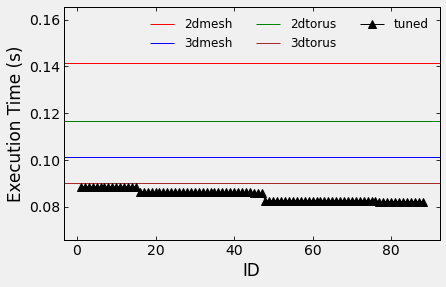

In [21]:
graph_tuning("cg.A.64.log", mesh2d=0.141583, mesh3d=0.10114, torus2d=0.116572, torus3d=0.0901337, axis="id")

# result of LU

# result of MG

In [22]:
# graph_tuning("mg.A.64.log", mesh2d=0.0230132, mesh3d=0.0177169, torus2d=0.0166326, torus3d=0.0110109)

In [23]:
# graph_tuning("mg.A.64.3600.log", mesh2d=0.0230132, mesh3d=0.0177169, torus2d=0.0166326, torus3d=0.0110109)

# result of SP

In [24]:
# graph_tuning("sp.A.64.log", mesh2d=0.812781, mesh3d=0.564094, torus2d=0.192574, torus3d=0.334719)

# result of FT

In [25]:
# graph_log("ft.A.64.log")

In [26]:
# graph_tuning("ft.A.64.log", mesh2d=0.0421358, mesh3d=0.0283606, torus2d=0.0216406, torus3d=0.0186732)

# result of MM (-K 4096 -B 64)

In [27]:
# graph_tuning("mm.64.log", mesh2d=0.0305389, mesh3d=0.0225248, torus2d=0.0223532, torus3d=0.0193511)

# Graph500 (64 8)

In [28]:
# graph_tuning("graph500.64.3600.log", mesh2d=2.55341, mesh3d=2.48414, torus2d=2.66482, torus3d=2.78923, last=2000)

In [29]:
# graph_tuning("graph500.64.3600.log", mesh2d=2.55341, mesh3d=2.48414, torus2d=2.66482, torus3d=2.78923, axis="id", last=40)

# Himeno (S)

In [30]:
# graph_tuning("himeno.64.log", mesh2d=0.187648, mesh3d=0.138043, torus2d=0.142489, torus3d=0.107125)